# 이 노트의 목표
---
1. 3/08, 3/11 노트 정리
2. 비율대로 좌표구해주는 함수 고민




In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [188]:
# import

import librosa
import librosa.display
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.patches as patches
import io


In [3]:
# dir

database_dir = '/content/drive/MyDrive/aiffel/AIFFELthon/1_data/ICBHI_final_database/'
train_test_dir = '/content/drive/MyDrive/aiffel/AIFFELthon/1_data/ICBHI_challenge_train_test.txt'


## 함수1 : get_dataframe

1. return1 : wav, txt 파일명 반환하는 튜플리스트 -> [ (wav, txt), ...  ]
2. return2 : 오디오파일 df 생성

|idx|filename|start|end|crackles|wheezes|duration|train-test|
|---|---|---|---|---|---|---|---|
|0|||||||||
|1|||||||||
|2|||||||||




In [4]:
# dir내의 파일을 이름으로 같이 묶어서 반환하는 함수 -> [ (wav, txt), ( ... ), ... ]

def get_dataframe(database_dir, train_test_dir, sr = 8000):
    '''
    database_dir : raw database (include wav, txt files)
    train_test_dir: train, test 정보 포함된 txt 경로
    '''
    # 디렉토리 내의 모든 파일 목록을 가져옵니다.
    all_files = os.listdir(database_dir)

    wav_files = [file for file in all_files if file.endswith('.wav')]
    txt_files = [file for file in all_files if file.endswith('.txt')]

    # 파일명(확장자 제외)을 기준으로 .wav와 .txt 파일이 모두 있는 경우를 찾아서 짝지어 줍니다.
    wav_txt_name = []
    for wav_file in wav_files:
        file_name_without_extension = os.path.splitext(wav_file)[0] # 확장자를 제외한 파일명

        matching_txt_file = file_name_without_extension + '.txt' # 해당 파일명을 가진 .txt 파일이 있는지 확인
        if matching_txt_file in txt_files:
            wav_txt_name.append((wav_file, matching_txt_file)) # : wav_txt_name = [(filename.wav, filename.txt), ... ]
            # wav_txt_name -> "return1"

    # wav filename만 불러오고, duration 계산
    duration_ls = []
    wav_filename_ls = []
    for i, _ in wav_txt_name:          # wav 파일 이름만 가져옴
        wav_filename_ls.append(i)

        wav_path = database_dir + i
        y, sr = librosa.load(wav_path, sr=sr)
        duration = librosa.get_duration(y=y, sr=sr)
        duration_ls.append(duration)

    # ICBHI_challenge_train_test.txt 파일을 읽어서 DataFrame에 추가할 정보를 추출
    train_test_ls = []
    with open(train_test_dir, 'r') as file:
        for line in file:
            parts = line.strip().split('\t')
            filename = parts[0] + '.wav'  # WAV 파일 이름으로 변환
            train_test = parts[1]  # train 또는 test 값
            train_test_ls.append({'WAV Filename': filename, 'Train_Test': train_test})

    # get dataframe(1) - filename, duration
    wav_duration_df = pd.DataFrame({
        'WAV Filename': wav_filename_ls,
        'Duration': duration_ls
    })

    # ICBHI_challenge_train_test.txt 파일을 읽어서 DataFrame에 추가할 정보를 추출
    train_test_ls = []
    with open(train_test_dir, 'r') as file:
        for line in file:
            parts = line.strip().split('\t')
            filename = parts[0] + '.wav'  # WAV 파일 이름으로 변환
            train_test = parts[1]  # train 또는 test 값
            train_test_ls.append({'WAV Filename': filename, 'Train_Test': train_test})
    train_test_df = pd.DataFrame(train_test_ls)

    # get dataframe(2) : 원래 DataFrame과 새로운 DataFrame을 'WAV Filename'을 기준으로 병합 -> "return2"
    merged_df = pd.merge(wav_duration_df, train_test_df, on='WAV Filename', how='left')

    return wav_txt_name, merged_df


In [5]:
# test
wav_txt_name, merged_df = get_dataframe(database_dir, train_test_dir, sr = 8000)

In [28]:
print(type(wav_txt_name), type(merged_df))
print(len(wav_txt_name))
merged_df.head()

<class 'list'> <class 'pandas.core.frame.DataFrame'>
920


,WAV Filename,Duration,Train_Test
0,101_1b1_Al_sc_Meditron.wav,20.000,test
1,101_1b1_Pr_sc_Meditron.wav,20.000,test
2,102_1b1_Ar_sc_Meditron.wav,20.000,test
3,103_2b2_Ar_mc_LittC2SE.wav,20.000,train
4,104_1b1_Al_sc_Litt3200.wav,15.856,test


## 함수2 : get_annot_df
- 하나의 wav file에 대한 anno df 반환

['start', 'end', 'crackle', 'wheeze']

In [7]:
# 하나의 annotation dataframe
txt_path = database_dir + wav_txt_name[0][1]

tmp_df = pd.read_csv(txt_path,
               sep='\t',
               names = ['start', 'end', 'crackle', 'wheeze'])
tmp_df.head()

,start,end,crackle,wheeze
0,0.036,0.579,0,0
1,0.579,2.450,0,0
2,2.450,3.893,0,0
3,3.893,5.793,0,0
4,5.793,7.521,0,0


In [8]:
# merged_df idx정보로 annotation df 생성

def get_annot_df(idx, merged_df, database_dir):
    filename = merged_df['WAV Filename'][idx].replace('.wav', '.txt')
    txt_path = database_dir + filename
    annot_df = pd.read_csv(txt_path,
               sep='\t',
               names = ['start', 'end', 'crackle', 'wheeze'])
    annot_df.insert(0, 'WAV Filename', value=merged_df['WAV Filename'][idx])
    return annot_df


In [9]:
get_annot_df(0, merged_df, database_dir)


,WAV Filename,start,end,crackle,wheeze
0,101_1b1_Al_sc_Meditron.wav,0.036,0.579,0,0
1,101_1b1_Al_sc_Meditron.wav,0.579,2.450,0,0
2,101_1b1_Al_sc_Meditron.wav,2.450,3.893,0,0
3,101_1b1_Al_sc_Meditron.wav,3.893,5.793,0,0
4,101_1b1_Al_sc_Meditron.wav,5.793,7.521,0,0
5,101_1b1_Al_sc_Meditron.wav,7.521,9.279,0,0
6,101_1b1_Al_sc_Meditron.wav,9.279,11.150,0,0
7,101_1b1_Al_sc_Meditron.wav,11.150,13.036,0,0
8,101_1b1_Al_sc_Meditron.wav,13.036,14.721,0,0
9,101_1b1_Al_sc_Meditron.wav,14.721,16.707,0,0


In [10]:
# train-test df split

def split_train_test_df(merged_df):
    train_df = merged_df[merged_df['Train_Test'] == 'train']
    test_df = merged_df[merged_df['Train_Test'] == 'test']
    return train_df, test_df

In [11]:
train_df, test_df = split_train_test_df(merged_df)

In [12]:
print(train_df.shape)
train_df.head()

(538, 3)


,WAV Filename,Duration,Train_Test
3,103_2b2_Ar_mc_LittC2SE.wav,20.0,train
10,105_1b1_Tc_sc_Meditron.wav,20.0,train
11,106_2b1_Pl_mc_LittC2SE.wav,20.0,train
12,106_2b1_Pr_mc_LittC2SE.wav,20.0,train
13,107_2b3_Al_mc_AKGC417L.wav,20.0,train


In [13]:
print(test_df.shape)
test_df.head()

(381, 3)


,WAV Filename,Duration,Train_Test
0,101_1b1_Al_sc_Meditron.wav,20.000,test
1,101_1b1_Pr_sc_Meditron.wav,20.000,test
2,102_1b1_Ar_sc_Meditron.wav,20.000,test
4,104_1b1_Al_sc_Litt3200.wav,15.856,test
5,104_1b1_Ar_sc_Litt3200.wav,25.584,test


## 함수3 : audio2mspec_save

### mel spec 변수 테스트

1. `n_fft` (FFT window size): Fast Fourier Transform(FFT)를 적용할 윈도우의 크기입니다. 이 값이 크면 주파수 해상도는 높아지지만, 시간 해상도는 낮아집니다.
2. `hop_length`: 연속적인 프레임 사이의 이동하는 샘플의 수입니다. 이 값이 작으면 스펙트로그램의 "길이"가 늘어납니다.
3. `win_length`: 실제 분석에 사용되는 각 프레임의 윈도우 길이입니다. n_fft보다 작거나 같습니다.


주어진 조건(샘플 레이트가 8000Hz, 원하는 길이가 20초)에서 스펙트로그램의 시간 축이 정확히 20초가 되려면, <u>**hop_length와 n_fft를 조정**</u>해야 합니다. 여기서 중요한 점은 hop_length가 시간 축에 미치는 영향입니다.

hop_length가 시간 축에 미치는 영향

스펙트로그램의 시간 축 길이
> - 시간 축 길이(초) = (스펙트로그램의 열 수 * hop_length) / 샘플 레이트
> - 스펙트로그램의 열 수 = 1 + (샘플 수 - n_fft) / hop_length


샘플 레이트가 8000Hz이고, 오디오의 길이가 20초라면, 총 샘플 수는 8000 * 20 = 160000 샘플

스펙트로그램의 열 수를 적절히 조정하여
시간 축이 20초가 되도록 hop_length나 n_fft를 조절할 수 있습니다.

하지만 주어진 설정(hop_length = nfft // 2, nfft = 256)으로는
이미 hop_length가 n_fft의 절반으로 설정되어 있어,
이러한 조건 하에서 hop_length와 n_fft를 조정하여 정확히 20초로 맞추는 것은 복잡할 수 있습니다.

따라서, 시간 축을 정확히 조절하려면 스펙트로그램을 생성한 후에 결과의 시간 축을 오디오 길이에 맞게 조정하는 추가적인 단계가 필요할 수 있습니다. 예를 들어, 결과 스펙트로그램의 시간 축을 재조정하거나, hop_length를 늘리거나 줄여서 실험적으로 최적의 값을 찾는 방법 등이 있습니다.

Librosa의 librosa.feature.melspectrogram 함수를 사용하여 스펙트로그램을 생성할 때, hop_length와 n_fft

이외에도 다양한 파라미터(예: fmax, n_mels 등)를 조절할 수 있지만, 이러한 파라미터들은 주로 "주파수 축의 해상도"에 영향을 미치며, 시간 축 길이를 직접 조절하는 데는 제한적입니다.

In [14]:
# root 설정
root = '/content/drive/MyDrive/aiffel/AIFFELthon/1_data/ICBHI_final_database/'
samplefilename = '156_8b3_Ll_mc_AKGC417L.wav'
annotation = '156_8b3_Ll_mc_AKGC417L.txt'
audiopath = root + samplefilename
annopath = root + annotation

print(audiopath)
print(annopath)

/content/drive/MyDrive/aiffel/AIFFELthon/1_data/ICBHI_final_database/156_8b3_Ll_mc_AKGC417L.wav
/content/drive/MyDrive/aiffel/AIFFELthon/1_data/ICBHI_final_database/156_8b3_Ll_mc_AKGC417L.txt


Time axis range: 0.0 seconds to 40.0 seconds
Mel frequency axis range: 0.0 Hz to 1999.9999999999998 Hz


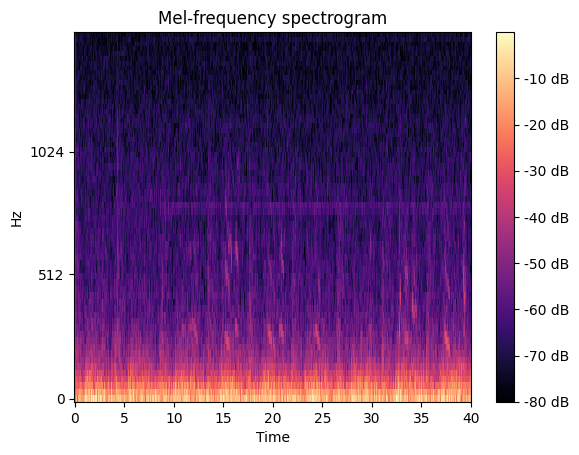

<Figure size 1000x400 with 0 Axes>

In [15]:
# Mel spec 조정
sample_rate = 8000  # 샘플링 레이트
desired_length = 8  # 원하는 길이 (이 값은 melspectrogram 함수에 직접 사용되지 않음)
n_mels = 64  # 멜 필터뱅크의 수
nfft = 512  # FFT 윈도우 크기
hop_length = nfft // 2  # 프레임 사이의 샘플 수
f_max = 2000  # 최대 주파수

y, sr = librosa.load(audiopath, sr=sample_rate)
S = librosa.feature.melspectrogram(y=y, sr=sample_rate, n_fft=nfft, hop_length=hop_length, n_mels=n_mels, fmax=f_max)
S_dB = librosa.power_to_db(S, ref=np.max)


fig, ax = plt.subplots()
img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, fmax=f_max, ax=ax)

plt.figure(figsize=(10, 4))
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')


# X축: 시간 축 크기 계산
frames = np.arange(S_dB.shape[1])
times = librosa.frames_to_time(frames, sr=sr)

# Y축: 멜 주파수 축 크기 계산
mel_frequencies = librosa.mel_frequencies(n_mels=S_dB.shape[0], fmax=f_max)

print(f"Time axis range: {times.min()} seconds to {times.max()} seconds")
print(f"Mel frequency axis range: {mel_frequencies.min()} Hz to {mel_frequencies.max()} Hz")

생각해보면 이 표현 방식에 상관없이 <br>
이미지로 저장한 데이터에서 비율을 찾아서 좌표를 전달해줄건데 <br>

여기서 이제 생각해볼건
- 좌표 위치는 이거랑 관련없다는 결론에
- 이 변수들의 조절은 "해상도" 랑만 관련있다는것
    - 실험적으로 적합한 값을 이론이랑 비교해가면서 결과 잘나오는 방향으로 찾으면 됨

<br>

그럼 이 실험을 하려먼 매번 결과가 달라진 새로운 데이터셋을 만드는게 아니라:

### <u>데이터 로더 결과값에 해당 데이터 표현을 담아서 모델에 전달해주는게 맞는듯</u>
- 일단은 아래 함수로 베이스라인용 데이터셋부터 만들어 두고
- 데이터 로더 자체는 베이스라인 돌린 후에 고민

### 함수에 적용

In [16]:

# convert_audio_to_melspectrogram

def audio2mspec_save(audio_path, save_path, size=(224, 224)):
    '''
    args:
        audio_path : 변환할 오디오 파일 경로
        save_path : 이미지 저장할 경로
        size : 변환할 이미지 pixel사이즈

    오디오 파일 경로를 받아서 저장 경로에 (224, 224, 3) 크기의 filename_mSpec.jpg 저장
    0. 변수 지정
    1. 파일이름, 디렉토리 정의
    2. audio -> mel
    3. mel -> image(jpg) -> resizing
    4. save image
    '''
    # 0. mel 변수 지정 -> 함수 매개변수로 옮겨도 되는 부분
    sample_rate = 8000  # 샘플링 레이트 (or 16000)
    n_mels = 64  # 멜 필터뱅크의 수
    nfft = 512  # FFT 윈도우 크기
    hop_length = nfft // 2  # 프레임 사이의 샘플 수
    f_max = 2000  # 최대 주파수

    # 1. .wav -> .jpg
    # .wav 파일 경로에서 디렉터리와 파일명(확장자 포함) 분리
    dir_path, filename = os.path.split(audio_path)
    # 파일명에서 확장자를 제거하고, .jpg 확장자를 추가
    base_filename = os.path.splitext(filename)[0]
    jpg_filename = f"{base_filename}_mSpec.jpg"
    # 디렉터리 내에 .jpg 파일 경로 생성
    save_path += jpg_filename


    # 2. to mel
    y, sr = librosa.load(audio_path, sr=sample_rate)
    S = librosa.feature.melspectrogram(y=y,
                                       sr=sr,
                                       n_fft=nfft,
                                       hop_length=hop_length,
                                       n_mels=n_mels,
                                       fmax=f_max)
    S_dB = librosa.power_to_db(S, ref=np.max)


    # 3. to img
    plt.figure(figsize=(2.24, 2.24))  # 이미지 크기를 인치 단위로 설정 (224x224 픽셀이 되도록 DPI 조정 필요)
    ax = plt.axes([0,0,1,1], frameon=False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.autoscale(tight=True)
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')

    # 이미지로 저장하기 전에 buffer에 저장
    plt.savefig(save_path, dpi=100)  # DPI를 조정하여 대략적인 픽셀 크기 맞춤
    #plt.savefig(save_path, bbox_inches='tight', pad_inches=0, dpi=100) # DPI를 조정하여 대략적인 픽셀 크기 맞춤
    plt.close()
    # 이미지를 다시 열어서 224x224x3으로 조정
    img = Image.open(save_path).convert('RGB')
    img = img.resize(size, Image.LANCZOS)


    # 4. save img
    if os.path.exists(save_path):
        pass
    else:
        img.save(save_path)

print('ㅎ')

ㅎ


In [17]:
# 사용

save_path = '/content/drive/MyDrive/aiffel/AIFFELthon/1_data/224mel_database240311/'

# for audio_file_name in wav_filename_ls:
#     audio_path = data_root_dir + audio_file_name

#     #audio2mspec_save(audio_path, save_path, size=(224,224)) # 사용할때 주석 제거
#     break

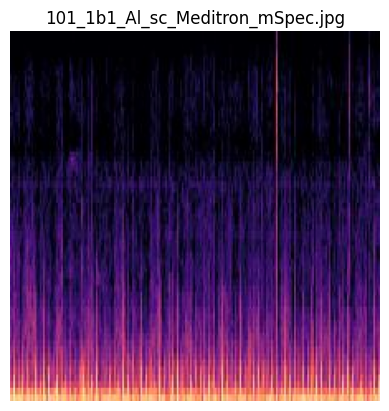

array([[[  0,   0,   4],
        [  0,   0,   4],
        [  0,   0,   4],
        ...,
        [  0,   0,   5],
        [  2,   1,   6],
        [  0,   0,   4]],

       [[  0,   0,   4],
        [  0,   0,   4],
        [  0,   0,   4],
        ...,
        [  0,   0,   4],
        [  2,   1,   6],
        [  0,   0,   4]],

       [[  0,   0,   4],
        [  0,   0,   4],
        [  0,   0,   4],
        ...,
        [  0,   0,   4],
        [  2,   1,   6],
        [  0,   0,   2]],

       ...,

       [[255, 196, 144],
        [236, 181, 125],
        [255, 231, 169],
        ...,
        [255, 204, 139],
        [238, 175, 121],
        [255, 209, 158]],

       [[254, 201, 149],
        [236, 189, 133],
        [255, 232, 170],
        ...,
        [255, 208, 148],
        [239, 183, 134],
        [255, 212, 169]],

       [[249, 199, 146],
        [235, 190, 133],
        [255, 229, 168],
        ...,
        [249, 198, 141],
        [237, 183, 137],
        [255, 210, 171]]], dtype=uint8)
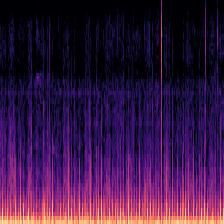

In [18]:
# sample file 확인
image_file = '/content/drive/MyDrive/aiffel/AIFFELthon/1_data/224mel_database240311/101_1b1_Al_sc_Meditron_mSpec.jpg'

tmp_img = Image.open(image_file)
tmp = np.array(tmp_img)

plt.figure()
plt.imshow(tmp_img)
plt.title(os.path.basename(image_file))
plt.axis('off')  # 축 표시 안 함
plt.show()

tmp

## 비율 고민 -> 3/13(수)


In [ ]:
# #

# pix_size = 224
# maxHz = f_max # (2000) 이부분은 mel 변환 고려해서 저장
# duration = 20 # 각 오디오 파일 길이

# wheeze_fmin = 200
# wheeze_fmax = 1200
# crackle_fmin = 100
# crackle_fmax = 200

# start = 1.935
# end = 4.185
# '''
# start, end -> column name

# '''

# # 비율 (224중 얼마 의 느낌으로 나옴)
# x_start = (start / duration) * pix_size
# x_end = (end / duration) * pix_size

# y_start = (1 - (crackle_fmax / f_max)) * pix_size
# y_end = (1 - (crackle_fmin / f_max)) * pix_size

# print('(x1, y1): ', '(', x_start, ',', y_start,')', '\t','(x2, y2): ', '(', x_end, ',', y_end, ')')

# # 비율 (0 ~ 1)사이 값으로 출력 고민
# duration = 20
# f_max = 2000

# # x 좌표 정규화
# x_start_norm = start / duration  # 0~1 사이의 값
# x_end_norm = end / duration      # 0~1 사이의 값

# # y 좌표 정규화
# y_start_norm = 1 - (crackle_fmax / f_max)
# y_end_norm = 1 - (crackle_fmin / f_max)
# print('(x1, y1): ', '(', x_start_norm, ',', y_start_norm,')', '\t','(x2, y2): ', '(', x_end_norm, ',', y_end_norm, ')')

In [23]:
# merged_df 내의 156_8b3_Ll_mc_AKGC417L.wav 인덱스
index_of_sample = merged_df.loc[merged_df['WAV Filename'] == sample_filename].index[0]
index_of_sample

376

In [ ]:
merged_df.loc[merged_df['WAV Filename'] == sample_filename]['Duration']

376    20.0
Name: Duration, dtype: float64

### sample image loader

표현 좋은 데이터 이름 : 156_8b3_Ll_mc_AKGC417L.wav ~ idx: 376<br>
레이블 좋은 데이터 이름 : 110_1p1_Al_sc_Meditron.wav ~ idx: 49

/content/drive/MyDrive/aiffel/AIFFELthon/1_data/224mel_database240311/156_8b3_Ll_mc_AKGC417L_mSpec.jpg
156_8b3_Ll_mc_AKGC417L.wav
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
idx:  376


,WAV Filename,start,end,crackle,wheeze
0,156_8b3_Ll_mc_AKGC417L.wav,1.935,4.185,1,0
1,156_8b3_Ll_mc_AKGC417L.wav,4.185,6.566,1,1
2,156_8b3_Ll_mc_AKGC417L.wav,6.566,8.601,1,1
3,156_8b3_Ll_mc_AKGC417L.wav,8.601,10.839,1,1
4,156_8b3_Ll_mc_AKGC417L.wav,10.839,13.185,1,1
5,156_8b3_Ll_mc_AKGC417L.wav,13.185,15.423,1,1
6,156_8b3_Ll_mc_AKGC417L.wav,15.423,17.613,1,1
7,156_8b3_Ll_mc_AKGC417L.wav,17.613,19.946,1,1


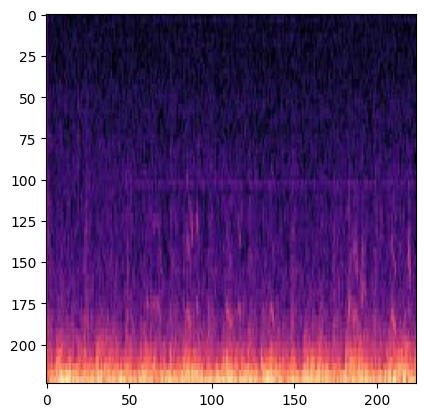

In [176]:
# 파일명으로 sample file 가져오는 함수 임시로 작성
# 110_1p1_Al_sc_Meditron

# 원하는 파일 이름 입력
sample_filename = '156_8b3_Ll_mc_AKGC417L.wav'

def sample_file_load(filename):

    save_path = '/content/drive/MyDrive/aiffel/AIFFELthon/1_data/224mel_database240311/'
    audio_path = '/content/drive/MyDrive/aiffel/AIFFELthon/1_data/ICBHI_final_database/' + filename
    audio2mspec_save(audio_path, save_path, size=(224,224))

    # sample file 확인
    img_dir = save_path + filename.replace('.wav', '_mSpec.jpg')
    print(img_dir)
    # load : '110_1p1_Al_sc_Meditron.wav'
    sample_img = Image.open(img_dir)
    sample_img_array = np.array(sample_img)
    '''
    plt.figure()
    plt.imshow(tmp_img)
    plt.title(os.path.basename(image_file))
    plt.axis('off')  # 축 표시 안 함
    plt.show()
    '''
    print(filename)
    print(type(sample_img))
    print(type(sample_img_array))
    #sample_img_array

    return sample_img


sample_img = sample_file_load(sample_filename)
plt.imshow(sample_img)
print('idx: ', merged_df.loc[merged_df['WAV Filename'] == sample_filename].index[0])
get_annot_df(merged_df.loc[merged_df['WAV Filename'] == sample_filename].index[0], merged_df, database_dir)



### 실험

In [92]:
# 다시...
'''
만들거: merged_df + 각 호흡당 좌표 포함된 dataframe

사용할 변수들
merged_df : 전체 dataframe
get_annot_df : annot_df 얻어줄 함수
annot_df : 해당 파일명 annotation text 파일 읽어서 나온 dataframe : ||||
sample_img : 224,224,3 <class 'PIL.JpegImagePlugin.JpegImageFile'>

crackle_fmin = 100
crackle_fmax = 200
wheeze_fmin = 200
wheeze_fmax = 1200

1. merged_df에서 filename, duration를 인덱스 순서대로 불러와서,
for문으로 다 읽을거긴 한데
일단 샘플파일 하나로 실험

2. filename에 맞는 anno_df 생성

3. 그 df에서 start, end, label 가져와서 비율대로 좌표 추출,
 리스트에 저장 후 새로운 데이터프레임으로 생성
 -> 여기가 문제

4. 새로 생성한 데이터프레임에 픽셀사이즈 적용시키는 함수

'''

f_max = 2000
wheeze_fmin = 200
wheeze_fmax = 1200
crackle_fmin = 100
crackle_fmax = 200

# 1.

for idx, row in merged_df.iterrows():
    filename = row['WAV Filename']
    duration = row['Duration']

    if idx > 49:
        continue
    # sample idx: 49
    if idx == 49:

        print(filename, duration)

        ls = []
        tmp_ls = []
        idx_anno_df = get_annot_df(idx, merged_df, database_dir)

        for idx2, row2 in idx_anno_df.iterrows():
            start = row2['start']
            end = row2['end']
            crackle = row2['crackle']
            wheeze = row2['wheeze']
            x1 = start / duration
            x2 = end / duration

            if crackle and wheeze:
                c_y1 = 1 - (crackle_fmin / f_max)
                c_y2 = 1 - (crackle_fmax / f_max)
                w_y1 = 1 - (wheeze_fmin / f_max)
                w_y2 = 1 - (wheeze_fmax / f_max)
                tmp_ls = [x1, c_y1, x2, c_y2, x1, w_y1, x2, w_y2]

            elif crackle and not wheeze:
                c_y1 = 1 - (crackle_fmin / f_max)
                c_y2 = 1 - (crackle_fmax / f_max)
                tmp_ls = [x1, c_y1, x2, c_y2, '', '', '', '']

            elif not crackle and wheeze:
                w_y1 = 1 - (wheeze_fmin / f_max)
                w_y2 = 1 - (wheeze_fmax / f_max)
                tmp_ls = ['', '', '', '', x1, w_y1, x2, w_y2]

            else: tmp_ls = ['', '', '', '', '', '', '', '']

            ls.append(tmp_ls)

        coordinate_df = pd.DataFrame(ls, columns = ['x_c1','y_c1','x_c2','y_c2','x_w1','y_w1','x_w2','y_w2'])
        concat_df = pd.concat([idx_anno_df, coordinate_df], axis=1)
            #print(start, end, crackle, wheeze)
            #break

        print(ls)
        break


'''
y = [c : x1, y1, x2, y2 | w : x1, y1, x2, y2 ]

idx | filename | s | e | c1, c2, c3, c4 | w1, w2, w3, w4 | c | w |


x_start = start / duration
x_start_norm = x_start * pix_size
x_end = end / duration
x_end_norm = (end / duration) * pix_size
w_y_start = 1 - (wheeze_fmax / f_max)
w_y_start_norm = w_y_start * pix_size
w_y_end = 1 - (wheeze_fmin / f_max)
w_y_end_norm = w_y_end * pix_size

'''
print()

110_1p1_Al_sc_Meditron.wav 32.3
[[0.07075851393188855, 0.95, 0.19395046439628483, 0.9, 0.07075851393188855, 0.9, 0.19395046439628483, 0.4], [0.19395046439628483, 0.95, 0.3232198142414861, 0.9, 0.19395046439628483, 0.9, 0.3232198142414861, 0.4], [0.3232198142414861, 0.95, 0.4369040247678019, 0.9, 0.3232198142414861, 0.9, 0.4369040247678019, 0.4], [0.4369040247678019, 0.95, 0.5639938080495356, 0.9, '', '', '', ''], ['', '', '', '', '', '', '', ''], [0.7155108359133128, 0.95, 0.8253250773993809, 0.9, '', '', '', ''], [0.8253250773993809, 0.95, 1.0, 0.9, '', '', '', '']]



In [93]:
for l in ls:
    print(l)

[0.07075851393188855, 0.95, 0.19395046439628483, 0.9, 0.07075851393188855, 0.9, 0.19395046439628483, 0.4]
[0.19395046439628483, 0.95, 0.3232198142414861, 0.9, 0.19395046439628483, 0.9, 0.3232198142414861, 0.4]
[0.3232198142414861, 0.95, 0.4369040247678019, 0.9, 0.3232198142414861, 0.9, 0.4369040247678019, 0.4]
[0.4369040247678019, 0.95, 0.5639938080495356, 0.9, '', '', '', '']
['', '', '', '', '', '', '', '']
[0.7155108359133128, 0.95, 0.8253250773993809, 0.9, '', '', '', '']
[0.8253250773993809, 0.95, 1.0, 0.9, '', '', '', '']


In [97]:
df49 = get_annot_df(merged_df.loc[merged_df['WAV Filename'] == filename].index[0], merged_df, database_dir)
df49

,WAV Filename,start,end,crackle,wheeze
0,110_1p1_Al_sc_Meditron.wav,2.2855,6.2646,1,1
1,110_1p1_Al_sc_Meditron.wav,6.2646,10.4400,1,1
2,110_1p1_Al_sc_Meditron.wav,10.4400,14.1120,1,1
3,110_1p1_Al_sc_Meditron.wav,14.1120,18.2170,1,0
4,110_1p1_Al_sc_Meditron.wav,18.2170,23.1110,0,0
5,110_1p1_Al_sc_Meditron.wav,23.1110,26.6580,1,0
6,110_1p1_Al_sc_Meditron.wav,26.6580,32.3000,1,0


In [96]:
tmpdf = pd.DataFrame(ls, columns = ['x_c1','y_c1','x_c2','y_c2','x_w1','y_w1','x_w2','y_w2'])
tmpdf

,x_c1,y_c1,x_c2,y_c2,x_w1,y_w1,x_w2,y_w2
0,0.070759,0.95,0.19395,0.9,0.070759,0.9,0.19395,0.4
1,0.19395,0.95,0.32322,0.9,0.19395,0.9,0.32322,0.4
2,0.32322,0.95,0.436904,0.9,0.32322,0.9,0.436904,0.4
3,0.436904,0.95,0.563994,0.9,,,,
4,,,,,,,,
5,0.715511,0.95,0.825325,0.9,,,,
6,0.825325,0.95,1.0,0.9,,,,


In [98]:
concat = pd.concat([df49, tmpdf], axis=1)
concat

,WAV Filename,start,end,crackle,wheeze,x_c1,y_c1,x_c2,y_c2,x_w1,y_w1,x_w2,y_w2
0,110_1p1_Al_sc_Meditron.wav,2.2855,6.2646,1,1,0.070759,0.95,0.19395,0.9,0.070759,0.9,0.19395,0.4
1,110_1p1_Al_sc_Meditron.wav,6.2646,10.4400,1,1,0.19395,0.95,0.32322,0.9,0.19395,0.9,0.32322,0.4
2,110_1p1_Al_sc_Meditron.wav,10.4400,14.1120,1,1,0.32322,0.95,0.436904,0.9,0.32322,0.9,0.436904,0.4
3,110_1p1_Al_sc_Meditron.wav,14.1120,18.2170,1,0,0.436904,0.95,0.563994,0.9,,,,
4,110_1p1_Al_sc_Meditron.wav,18.2170,23.1110,0,0,,,,,,,,
5,110_1p1_Al_sc_Meditron.wav,23.1110,26.6580,1,0,0.715511,0.95,0.825325,0.9,,,,
6,110_1p1_Al_sc_Meditron.wav,26.6580,32.3000,1,0,0.825325,0.95,1.0,0.9,,,,


In [68]:
for idx2, row2 in get_annot_df(49, merged_df, database_dir).iterrows():

    start = row2['start']
    end = row2['end']
    crackle = row2['crackle']
    wheeze = row2['wheeze']

    print(start, end, crackle, wheeze)

2.2855 6.2646 1 1
6.2646 10.44 1 1
10.44 14.112 1 1
14.112 18.217 1 0
18.217 23.111 0 0
23.111 26.658 1 0
26.658 32.3 1 0


In [101]:
merged_df['Duration'][0]

20.0

## 함수4: get_coordinate_df

In [159]:

def get_coordinate_df(idx, merged_df, database_dir):

    idx_anno_df = get_annot_df(idx, merged_df, database_dir)

    f_max = 2000
    wheeze_fmin = 200
    wheeze_fmax = 1200
    crackle_fmin = 100
    crackle_fmax = 200

    filename = merged_df['WAV Filename'][idx]
    duration = merged_df['Duration'][idx]

    # if idx > 49:
    #     continue
    # # sample idx: 49
    # if idx == 49:

    ls = []
    tmp_ls = []

    for idx2, row2 in idx_anno_df.iterrows():
        start = row2['start']
        end = row2['end']
        crackle = row2['crackle']
        wheeze = row2['wheeze']
        x1 = start / duration
        x2 = end / duration

        if crackle and wheeze:
            c_y1 = 1 - (crackle_fmin / f_max)
            c_y2 = 1 - (crackle_fmax / f_max)
            w_y1 = 1 - (wheeze_fmin / f_max)
            w_y2 = 1 - (wheeze_fmax / f_max)
            tmp_ls = [x1, c_y1, x2, c_y2, x1, w_y1, x2, w_y2]

        elif crackle and not wheeze:
            c_y1 = 1 - (crackle_fmin / f_max)
            c_y2 = 1 - (crackle_fmax / f_max)
            tmp_ls = [x1, c_y1, x2, c_y2, '', '', '', '']

        elif not crackle and wheeze:
            w_y1 = 1 - (wheeze_fmin / f_max)
            w_y2 = 1 - (wheeze_fmax / f_max)
            tmp_ls = ['', '', '', '', x1, w_y1, x2, w_y2]

        else: tmp_ls = ['', '', '', '', '', '', '', '']

        ls.append(tmp_ls)

    coordinate_df = pd.DataFrame(ls, columns = ['x_c1','y_c1','x_c2','y_c2','x_w1','y_w1','x_w2','y_w2'])
    concat_df = pd.concat([idx_anno_df, coordinate_df], axis=1)


    return concat_df

### 사용

In [155]:
# 사용

for i, _ in merged_df.iterrows():
    concat_df = get_coordinate_df(i, merged_df, database_dir)
    break

concat_df

,WAV Filename,start,end,crackle,wheeze,x_c1,y_c1,x_c2,y_c2,x_w1,y_w1,x_w2,y_w2
0,101_1b1_Al_sc_Meditron.wav,0.036,0.579,0,0,,,,,,,,
1,101_1b1_Al_sc_Meditron.wav,0.579,2.450,0,0,,,,,,,,
2,101_1b1_Al_sc_Meditron.wav,2.450,3.893,0,0,,,,,,,,
3,101_1b1_Al_sc_Meditron.wav,3.893,5.793,0,0,,,,,,,,
4,101_1b1_Al_sc_Meditron.wav,5.793,7.521,0,0,,,,,,,,
5,101_1b1_Al_sc_Meditron.wav,7.521,9.279,0,0,,,,,,,,
6,101_1b1_Al_sc_Meditron.wav,9.279,11.150,0,0,,,,,,,,
7,101_1b1_Al_sc_Meditron.wav,11.150,13.036,0,0,,,,,,,,
8,101_1b1_Al_sc_Meditron.wav,13.036,14.721,0,0,,,,,,,,
9,101_1b1_Al_sc_Meditron.wav,14.721,16.707,0,0,,,,,,,,


In [156]:
# get sample label

sample_filename = '156_8b3_Ll_mc_AKGC417L.wav'
sample_coo = get_coordinate_df(merged_df.loc[merged_df['WAV Filename'] == sample_filename].index[0], merged_df, database_dir)

sample_coo

,WAV Filename,start,end,crackle,wheeze,x_c1,y_c1,x_c2,y_c2,x_w1,y_w1,x_w2,y_w2
0,156_8b3_Ll_mc_AKGC417L.wav,1.935,4.185,1,0,0.09675,0.9,0.20925,0.95,,,,
1,156_8b3_Ll_mc_AKGC417L.wav,4.185,6.566,1,1,0.20925,0.9,0.32830,0.95,0.20925,0.4,0.3283,0.9
2,156_8b3_Ll_mc_AKGC417L.wav,6.566,8.601,1,1,0.32830,0.9,0.43005,0.95,0.3283,0.4,0.43005,0.9
3,156_8b3_Ll_mc_AKGC417L.wav,8.601,10.839,1,1,0.43005,0.9,0.54195,0.95,0.43005,0.4,0.54195,0.9
4,156_8b3_Ll_mc_AKGC417L.wav,10.839,13.185,1,1,0.54195,0.9,0.65925,0.95,0.54195,0.4,0.65925,0.9
5,156_8b3_Ll_mc_AKGC417L.wav,13.185,15.423,1,1,0.65925,0.9,0.77115,0.95,0.65925,0.4,0.77115,0.9
6,156_8b3_Ll_mc_AKGC417L.wav,15.423,17.613,1,1,0.77115,0.9,0.88065,0.95,0.77115,0.4,0.88065,0.9
7,156_8b3_Ll_mc_AKGC417L.wav,17.613,19.946,1,1,0.88065,0.9,0.99730,0.95,0.88065,0.4,0.9973,0.9


In [160]:
sample_coo2 = get_coordinate_df(49, merged_df, database_dir)
sample_coo2

,WAV Filename,start,end,crackle,wheeze,x_c1,y_c1,x_c2,y_c2,x_w1,y_w1,x_w2,y_w2
0,110_1p1_Al_sc_Meditron.wav,2.2855,6.2646,1,1,0.070759,0.95,0.19395,0.9,0.070759,0.9,0.19395,0.4
1,110_1p1_Al_sc_Meditron.wav,6.2646,10.4400,1,1,0.19395,0.95,0.32322,0.9,0.19395,0.9,0.32322,0.4
2,110_1p1_Al_sc_Meditron.wav,10.4400,14.1120,1,1,0.32322,0.95,0.436904,0.9,0.32322,0.9,0.436904,0.4
3,110_1p1_Al_sc_Meditron.wav,14.1120,18.2170,1,0,0.436904,0.95,0.563994,0.9,,,,
4,110_1p1_Al_sc_Meditron.wav,18.2170,23.1110,0,0,,,,,,,,
5,110_1p1_Al_sc_Meditron.wav,23.1110,26.6580,1,0,0.715511,0.95,0.825325,0.9,,,,
6,110_1p1_Al_sc_Meditron.wav,26.6580,32.3000,1,0,0.825325,0.95,1.0,0.9,,,,


## 박스 시각화 !!

```python
patches.Rectangle(
(x, y), w, h = (x_c1, y_c1), (x_c2 - x_c1), (y_c2 - y_c1)
)

```

(480, 640, 3)


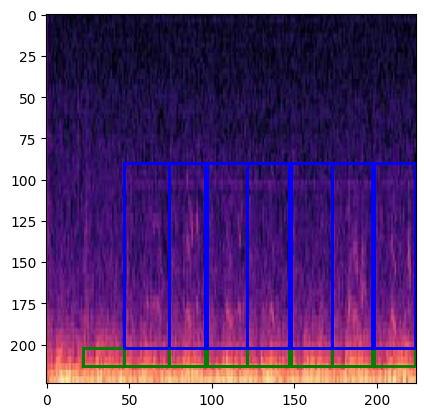

In [193]:
# 샘플파일이름 주면 박스 시각화
sample_filename = '156_8b3_Ll_mc_AKGC417L.wav'
sample_filename2 = '110_1p1_Al_sc_Meditron.wav'

sample_idx = merged_df.loc[merged_df['WAV Filename'] == sample_filename].index[0]

sample_coordinate = get_coordinate_df(sample_idx, merged_df, database_dir)


fig, ax = plt.subplots()

# 이미지 표시
ax.imshow(sample_img)

c_boxes = []
w_boxes = []
pix_size = 224

for idx, row in sample_coordinate.iterrows():
    # crackle
    if row['crackle']:
        x_c1 = round(row['x_c1'] * pix_size)
        y_c1 = round(row['y_c1'] * pix_size)
        w_c = round((row['x_c2'] - row['x_c1']) * pix_size)
        h_c = round(-(row['y_c1'] - row['y_c2']) * pix_size)
        c_boxes.append((x_c1,y_c1,w_c,h_c))

    elif not row['crackle']:
        c_boxes.append(())

    # wheeze
    if row['wheeze']:
        x_w1 = round(row['x_w1'] * pix_size)
        y_w1 = round(row['y_w1'] * pix_size)
        w_w = round((row['x_w2'] - row['x_w1']) * pix_size)
        h_w = round(-(row['y_w1'] - row['y_w2']) * pix_size)
        w_boxes.append((x_w1,y_w1,w_w,h_w))

    elif not row['wheeze']:
        w_boxes.append(())

    # print(x_c1,y_c1,w_c,h_c)
    # print(x_w1,x_w1,w_w,h_w)
    # print()

    # if idx == 6:
    #     print(c_boxes)
    #     print(w_boxes)

    for box in c_boxes:
        try :
            c_rect = patches.Rectangle((box[0], box[1]), box[2], box[3], linewidth=2, edgecolor='g', facecolor='none')
            ax.add_patch(c_rect)
        except:
            pass

    for box in w_boxes:
        try:
            b_rect = patches.Rectangle((box[0], box[1]), box[2], box[3], linewidth=2, edgecolor='b', facecolor='none')
            ax.add_patch(b_rect)
        except:
            pass

# 이미지를 버퍼에 저장
buf = io.BytesIO()
plt.savefig(buf, format='jpg')
buf.seek(0)

# Pillow를 사용하여 이미지 열기
image = Image.open(buf)

# NumPy 배열로 변환
image_array = np.array(image)

# 버퍼 닫기
buf.close()

# 사용 예: 이미지 배열 확인
print(image_array.shape)

plt.show()

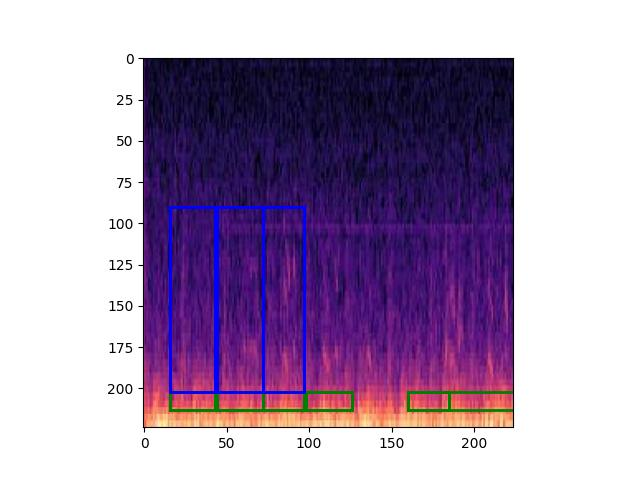

In [191]:
image

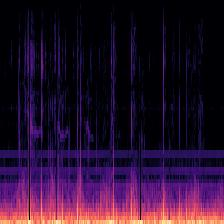

In [116]:
sample_img

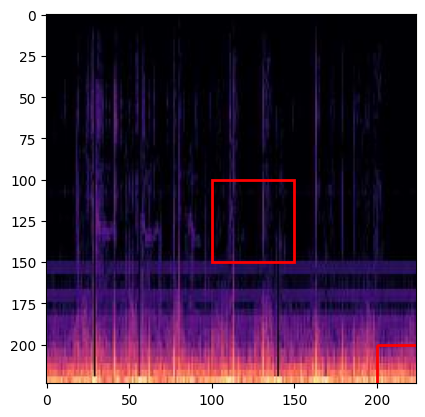

In [120]:

fig, ax = plt.subplots()

# 이미지 표시
ax.imshow(sample_img)

# 박스(사각형) 추가 정보: (x, y, width, height)
boxes = [
    (100, 100, 50, 50),  # 첫 번째 박스: (x, y, width, height)
    (200, 200, 100, 50), # 두 번째 박스
    # 여기에 필요한 만큼 박스를 추가할 수 있습니다.
]

# 박스(사각형) 그리기 crackle
for box in boxes:
    rect = patches.Rectangle((box[0], box[1]), box[2], box[3], linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

# 박스(사각형) 그리기 wheeze
for box in boxes:
    rect = patches.Rectangle((box[0], box[1]), box[2], box[3], linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)


# 표시
plt.show()



# tmp

In [ ]:
# 좌표값 고민
'''
merged_df에서 filename, duration 정보 받고,
해당 filename의 annotation dataframe 가져와서
start end 값들 정규화시킨 좌표값을 새로운 dataframe에 저장
'''

filename = merged_df['WAV Filename'][376]
duration = merged_df['Duration'][376]

print(filename)
print(duration)

sample156_df = get_annot_df(376, merged_df, database_dir)
sample156_df

156_8b3_Ll_mc_AKGC417L.wav
20.0


,WAV Filename,start,end,crackle,wheeze
0,156_8b3_Ll_mc_AKGC417L.wav,1.935,4.185,1,0
1,156_8b3_Ll_mc_AKGC417L.wav,4.185,6.566,1,1
2,156_8b3_Ll_mc_AKGC417L.wav,6.566,8.601,1,1
3,156_8b3_Ll_mc_AKGC417L.wav,8.601,10.839,1,1
4,156_8b3_Ll_mc_AKGC417L.wav,10.839,13.185,1,1
5,156_8b3_Ll_mc_AKGC417L.wav,13.185,15.423,1,1
6,156_8b3_Ll_mc_AKGC417L.wav,15.423,17.613,1,1
7,156_8b3_Ll_mc_AKGC417L.wav,17.613,19.946,1,1


WAV Filename | cBx1 | cBy1 | cBx2 | cBy2 | wBx1 | wBy1 | wBx2 | wBy2 | c1 | c2 |



1. 바운딩 박스 좌표: 각 객체에 대한 바운딩 박스의 좌표입니다. 이는 일반적으로
    - [xmin, ymin, xmax, ymax] 형식으로 표현되며, 여기서
    - (xmin, ymin)은 박스의 왼쪽 상단 모서리 좌표이고,
    - (xmax, ymax)는 박스의 오른쪽 하단 모서리 좌표입니다.

2. 클래스 레이블: 각 객체의 클래스를 나타냅니다. 2 클래스 탐지의 경우, 클래스 레이블은 보통 0과 1 또는 1과 2와 같이 정수로 표현됩니다. 예를 들어, 0(또는 1)은 첫 번째 클래스, 1(또는 2)은 두 번째 클래스를 의미할 수 있습니다.


In [ ]:
data_list = sample156_df.to_dict('records')
print(data_list)


[{'WAV Filename': '156_8b3_Ll_mc_AKGC417L.wav', 'start': 1.935, 'end': 4.185, 'crackle': 1, 'wheeze': 0}, {'WAV Filename': '156_8b3_Ll_mc_AKGC417L.wav', 'start': 4.185, 'end': 6.566, 'crackle': 1, 'wheeze': 1}, {'WAV Filename': '156_8b3_Ll_mc_AKGC417L.wav', 'start': 6.566, 'end': 8.601, 'crackle': 1, 'wheeze': 1}, {'WAV Filename': '156_8b3_Ll_mc_AKGC417L.wav', 'start': 8.601, 'end': 10.839, 'crackle': 1, 'wheeze': 1}, {'WAV Filename': '156_8b3_Ll_mc_AKGC417L.wav', 'start': 10.839, 'end': 13.185, 'crackle': 1, 'wheeze': 1}, {'WAV Filename': '156_8b3_Ll_mc_AKGC417L.wav', 'start': 13.185, 'end': 15.423, 'crackle': 1, 'wheeze': 1}, {'WAV Filename': '156_8b3_Ll_mc_AKGC417L.wav', 'start': 15.423, 'end': 17.613, 'crackle': 1, 'wheeze': 1}, {'WAV Filename': '156_8b3_Ll_mc_AKGC417L.wav', 'start': 17.613, 'end': 19.946, 'crackle': 1, 'wheeze': 1}]


In [ ]:
wheeze_fmin = 200
wheeze_fmax = 1200
crackle_fmin = 100
crackle_fmax = 200

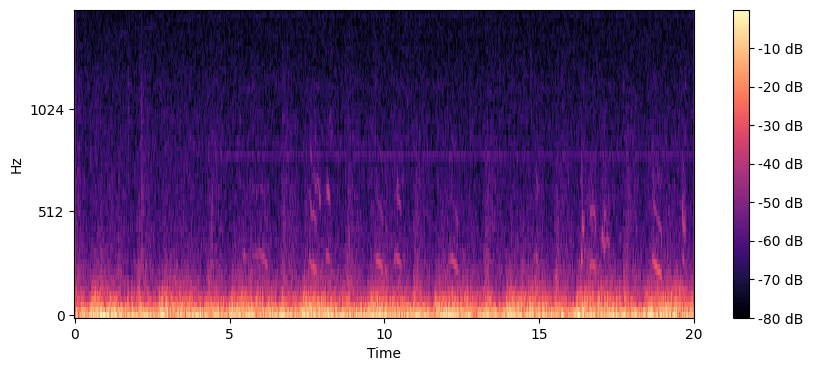

In [ ]:
# 오디오 파일 로딩
wav_file_path = database_dir + '156_8b3_Ll_mc_AKGC417L.wav'  # 오디오 파일 경로
y, sr = librosa.load(wav_file_path, sr=8000)  # y는 오디오 신호, sr은 샘플링 레이트

# 수정된 속성을 사용하여 멜 스펙트로그램 계산
S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=nfft, hop_length=hop_length, n_mels=n_mels, fmax=f_max)

# 멜 스펙트로그램을 디스플레이하기 위한 코드 (선택 사항)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(S, ref=np.max), sr=sample_rate, hop_length=hop_length, y_axis='mel', fmax=f_max, x_axis='time')
plt.colorbar(format='%+2.0f dB')

### 좌표 설정 실험


1.935 4.185 	 c: 1 w: 0
C:  (x1, y1):  ( 0 , 201.6 ) 	 (x2, y2):  ( 0 , 212.79999999999998 )
W:  (x1, y1):  ( 0 , 0 ) 	 (x2, y2):  ( 0 , 0 )

4.185 6.566 	 c: 1 w: 1
C:  (x1, y1):  ( 46.872 , 201.6 ) 	 (x2, y2):  ( 73.5392 , 212.79999999999998 )
W:  (x1, y1):  ( 46.872 , 89.60000000000001 ) 	 (x2, y2):  ( 73.5392 , 201.6 )

6.566 8.601 	 c: 1 w: 1
C:  (x1, y1):  ( 73.5392 , 201.6 ) 	 (x2, y2):  ( 96.33120000000001 , 212.79999999999998 )
W:  (x1, y1):  ( 73.5392 , 89.60000000000001 ) 	 (x2, y2):  ( 96.33120000000001 , 201.6 )

8.601 10.839 	 c: 1 w: 1
C:  (x1, y1):  ( 96.33120000000001 , 201.6 ) 	 (x2, y2):  ( 121.39680000000001 , 212.79999999999998 )
W:  (x1, y1):  ( 96.33120000000001 , 89.60000000000001 ) 	 (x2, y2):  ( 121.39680000000001 , 201.6 )

10.839 13.185 	 c: 1 w: 1
C:  (x1, y1):  ( 121.39680000000001 , 201.6 ) 	 (x2, y2):  ( 147.672 , 212.79999999999998 )
W:  (x1, y1):  ( 121.39680000000001 , 89.60000000000001 ) 	 (x2, y2):  ( 147.672 , 201.6 )

13.185 15.423 	 c: 1 w: 1
C: 

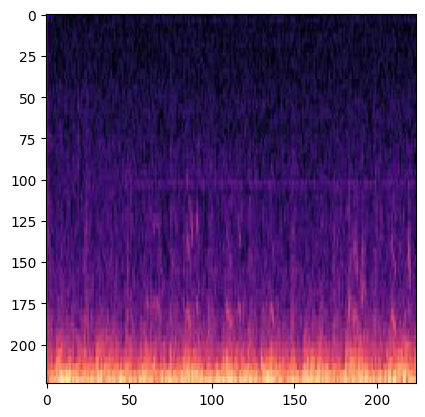

In [ ]:
# # 비율 (0 ~ 1)사이 값으로 출력 고민
# duration = 20
# f_max = 2000
# pix_size = 224

# # 시각화를 위한 기본 설정
# fig, ax = plt.subplots()
# ax.imshow(sample_img)

# # 초기화
# x_start = 0
# x_start_norm = 0
# x_end = 0
# x_end_norm = 0
# c_y_start = 0
# c_y_start_norm = 0
# c_y_end = 0
# c_y_end_norm = 0
# w_y_start = 0
# w_y_start_norm = 0
# w_y_end = 0
# w_y_end_norm = 0

# for entry in data_list:

#     start = entry["start"]
#     end = entry["end"]
#     crackles = entry["crackle"]
#     wheezes = entry["wheeze"]
#     print(start, end, '\t', 'c:', crackles, 'w:', wheezes )

#     # 좌표 저장
#     # 둘 다 0일 경우
#     if not crackles and not wheezes:
#         continue

#     # crackles 1일 경우
#     if crackles:
#         # crackles 1일 경우
#         x_start = start / duration
#         x_start_norm = x_start * pix_size
#         x_end = end / duration
#         x_end_norm = (end / duration) * pix_size
#         c_y_start = 1 - (crackle_fmax / f_max)
#         c_y_start_norm = c_y_start * pix_size
#         c_y_end = 1 - (crackle_fmin / f_max)
#         c_y_end_norm = c_y_end * pix_size

#     # crackles 1일 경우
#     elif not crackles:
#         # crackles 1일 경우
#         x_start = 0
#         x_start_norm = 0
#         x_end = 0
#         x_end_norm = 0
#         c_y_start = 0
#         c_y_start_norm = 0
#         c_y_end = 0
#         c_y_end_norm = 0
#     # wheezes 1일 경우
#     if wheezes:
#         x_start = start / duration
#         x_start_norm = x_start * pix_size
#         x_end = end / duration
#         x_end_norm = (end / duration) * pix_size
#         w_y_start = 1 - (wheeze_fmax / f_max)
#         w_y_start_norm = w_y_start * pix_size
#         w_y_end = 1 - (wheeze_fmin / f_max)
#         w_y_end_norm = w_y_end * pix_size
#     elif not wheezes:
#         x_start = 0
#         x_start_norm = 0
#         x_end = 0
#         x_end_norm = 0
#         w_y_start = 0
#         w_y_start_norm = 0
#         w_y_end = 0
#         w_y_end_norm = 0

#     c_tmp = [x_start_norm,
#              c_y_start_norm,
#              x_end_norm - x_start_norm,
#              c_y_end_norm - c_y_start_norm]
#     w_tmp = [x_start_norm,
#              w_y_start_norm,
#              x_end_norm - x_start_norm,
#              w_y_end_norm - w_y_start_norm]

#     print('C: ', '(x1, y1): ', '(', x_start_norm, ',', c_y_start_norm,')', '\t','(x2, y2): ', '(', x_end_norm, ',', c_y_end_norm, ')')
#     print('W: ', '(x1, y1): ', '(', x_start_norm, ',', w_y_start_norm,')', '\t','(x2, y2): ', '(', x_end_norm, ',', w_y_end_norm, ')')
#     print()

#     # 사각형 영역 표시
#     c_rect = patches.Rectangle((x_start, c_y_start), x_end - x_start, c_y_end - c_y_start, linewidth=1, edgecolor='g', facecolor='none')
#     w_rect = patches.Rectangle((x_start, w_y_start), x_end - x_start, w_y_end - w_y_start, linewidth=1, edgecolor='b', facecolor='none')

#     ax.add_patch(c_rect)
#     ax.add_patch(w_rect)



# plt.show()

